### Data distribution among two clients and testset

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from collections import defaultdict
import random

# Define transformations
data_transform = transforms.Compose([
    transforms.Resize((14, 14)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Load the dataset
dataset_all = ImageFolder('Ayana_Bharti/train_mnist_all', transform=data_transform)

# Organize dataset indices by class
def organize_indices_by_class(dataset):
    """
    Organize dataset indices by their class labels.
    
    Args:
        dataset: The dataset with labels to split.
        
    Returns:
        Dictionary with class labels as keys and corresponding indices as values.
    """
    class_indices = defaultdict(list)
    for idx, data in enumerate(dataset):
        _, label = data
        class_indices[label].append(idx)
    return class_indices


# Split dataset for non-IID simulation
def split_dataset_for_non_iid(class_indices, val_ratio=0.2):
    """
    Splits the dataset into non-IID training and validation indices for clients.

    Args:
        class_indices: Dictionary of class label -> list of sample indices.
        val_ratio: Proportion of samples to reserve for validation.

    Returns:
        Tuple of train and validation indices for each client and the test set.
    """
    train_indices_client1, train_indices_client2 = [], []
    val_indices_client1, val_indices_client2 = [], []

    for label in range(10):  # MNIST classes: 0-9
        class_samples = class_indices[label]
        if not class_samples:
            continue  # Skip empty classes
        class_split = int(val_ratio * len(class_samples))
        class_split = max(1, class_split)  # Ensure at least 1 sample for validation if possible

        if label in [0, 1, 2]:  # Client 1 classes
            val_indices_client1.extend(class_samples[:class_split])
            train_indices_client1.extend(class_samples[class_split:])
        elif label in [3, 4, 5]:  # Client 2 classes
            val_indices_client2.extend(class_samples[:class_split])
            train_indices_client2.extend(class_samples[class_split:])

    return train_indices_client1, train_indices_client2, val_indices_client1, val_indices_client2

# Create Subsets
def create_subsets(dataset, indices):
    """
    Creates a subset of the dataset based on the provided indices.
    
    Args:
        dataset: The complete dataset.
        indices: List of indices to include in the subset.
        
    Returns:
        Subset object containing the specified indices.
    """
    return Subset(dataset, indices)

# DataLoaders
def create_dataloader(subset, batch_size=64, shuffle=True):
    """
    Creates a DataLoader for the provided dataset subset.
    
    Args:
        subset: The dataset subset.
        batch_size: Number of samples per batch.
        shuffle: Whether to shuffle the data.
        
    Returns:
        DataLoader object.
    """
    if len(subset) == 0:
        raise ValueError("Subset is empty. Ensure data split logic is correct.")
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle)



# Organize indices by class
class_indices = organize_indices_by_class(dataset_all)

# Split dataset for non-IID simulation
train_indices_client1, train_indices_client2, val_indices_client1, val_indices_client2 = split_dataset_for_non_iid(class_indices, val_ratio=0.2)

# Create Subsets
subset_client1 = create_subsets(dataset_all, train_indices_client1)
subset_client2 = create_subsets(dataset_all, train_indices_client2)
subset_val_client1 = create_subsets(dataset_all, val_indices_client1)
subset_val_client2 = create_subsets(dataset_all, val_indices_client2)

# DataLoaders
batch_size = 64
loader_client1 = create_dataloader(subset_client1, batch_size=batch_size, shuffle=True)
loader_client2 = create_dataloader(subset_client2, batch_size=batch_size, shuffle=True)
val_loader_client1 = create_dataloader(subset_val_client1, batch_size=batch_size, shuffle=False)
val_loader_client2 = create_dataloader(subset_val_client2, batch_size=batch_size, shuffle=False)
test_loader = create_dataloader(dataset_all, batch_size=batch_size, shuffle=False)

# Summary of Data Distribution
print(f"Client 1 training samples: {len(subset_client1)}, validation samples: {len(subset_val_client1)}")
print(f"Client 2 training samples: {len(subset_client2)}, validation samples: {len(subset_val_client2)}")



Client 1 training samples: 21760, validation samples: 5438
Client 2 training samples: 20351, validation samples: 5086


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size=14 * 14, hidden_sizes=(128, 64), output_size=9, dropout=0.2):
        """
        A flexible Multi-Layer Perceptron (MLP) for non-IID federated learning.

        Parameters:
        - input_size: Size of the flattened input (default is 14*14 for MNIST-like data).
        - hidden_sizes: Tuple defining the sizes of the hidden layers.
        - output_size: Number of output classes (default is 10).
        - dropout: Dropout probability to mitigate overfitting (default is 0.2).
        """
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Define layers
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)

        # Add dropout layers
        self.dropout = nn.Dropout(dropout)

        # Add optional batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters:
        - x: Input tensor of shape (batch_size, input_size).

        Returns:
        - logits: Output predictions before softmax.
        """
        x = x.view(x.size(0), -1)  # Flatten the input

        # First layer with batch normalization
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        # Second layer with batch normalization
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        # Output layer (logits, no activation)
        x = self.fc3(x)
        return x


In [4]:
def train_model(model, dataloader, num_epochs, learning_rate, val_loader=None, device='cpu'):
    """
    Trains a PyTorch model using the provided dataloader, loss function, and optimizer.

    Parameters:
    - model: The neural network to train.
    - dataloader: DataLoader containing the training data.
    - num_epochs: Number of epochs to train the model.
    - learning_rate: Learning rate for the optimizer.
    - val_loader: DataLoader for validation data (optional).
    - device: The device to train on ('cpu' or 'cuda').

    Returns:
    - model: The trained model.
    """
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Move the model to the specified device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        correct = 0
        total_samples = 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model

            optimizer.zero_grad()  # Clear the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update the weights

            total_loss += loss.item()  # Sum up the batch loss
            _, predicted = torch.max(outputs, 1)  # Get predictions
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total_samples += labels.size(0)  # Update total samples

        # Compute average loss and accuracy
        avg_loss = total_loss / len(dataloader)
        accuracy = correct / total_samples * 100

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # Optional validation metrics
        if val_loader:
            val_accuracy, val_loss = evaluate_model(model, val_loader, criterion, device)
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return model

def evaluate_model(models, dataloaders, criterion, device='cpu'):
    """
    Evaluates multiple models on their respective validation sets.
    
    Args:
        models (dict): Dictionary of model instances (e.g., {'client1': model1, 'client2': model2}).
        dataloaders (dict): Dictionary of corresponding dataloaders (e.g., {'client1': loader1, 'client2': loader2}).
        criterion (torch.nn.Module): Loss function.
        device (str): Device to run evaluation on ('cpu' or 'cuda').
    
    Returns:
        dict: Performance metrics for each model (e.g., accuracy, loss).
    """
    performance = {}
    for client_id, model in models.items():
        model.to(device)
        model.eval()  # Set the model to evaluation mode

        total_loss = 0.0
        correct = 0
        total_samples = 0

        dataloader = dataloaders[client_id]
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total_samples += labels.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = correct / total_samples
        performance[client_id] = {'accuracy': accuracy, 'loss': avg_loss}

    return performance



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def analyze_dataset_diversity(client_dataloaders):
    """
    Visualizes the label distribution across client datasets in a non-IID setup.

    Args:
    - client_dataloaders: Dictionary of client_id -> DataLoader.
    """
    label_distribution = defaultdict(list)

    for client_id, dataloader in client_dataloaders.items():
        labels = []
        for _, label_batch in dataloader:
            labels.extend(label_batch.numpy())  # Collect all labels from the DataLoader

        unique, counts = np.unique(labels, return_counts=True)
        for u, c in zip(unique, counts):
            label_distribution[u].append((client_id, c))

    # Visualize the distribution
    plt.figure(figsize=(10, 6))
    for label, distributions in label_distribution.items():
        clients, counts = zip(*distributions)
        plt.bar(clients, counts, label=f"Label {label}")

    plt.xlabel("Clients")
    plt.ylabel("Sample Count")
    plt.title("Label Distribution Across Clients (Non-IID)")
    plt.legend()
    plt.show()


### server averaging function

In [6]:
import os
import torch

def server_averaging_non_iid(*local_models, device='cpu'):
    """
    Averages the parameters of multiple local models to create a global model.

    Parameters:
    - *local_models: Variable number of trained local models (e.g., model_all1, model_all2).
    - device: The device ('cpu' or 'cuda') to perform computations on.

    Returns:
    - server_model: The globally averaged model.
    """
    if len(local_models) < 2:
        raise ValueError("At least two models are required for averaging.")

    # Ensure all local models are moved to the correct device and extract their state dictionaries
    local_state_dicts = [model.to(device).state_dict() for model in local_models]

    # Initialize the global model
    server_model = MLP().to(device)
    averaged_params = {}

    # Check if all models have the same architecture (parameter shapes)
    state_dict_keys = [list(model.state_dict().keys()) for model in local_models]
    if any(keys != state_dict_keys[0] for keys in state_dict_keys):
        raise ValueError("All models must have the same architecture (parameter shapes).")

    # Parameter Averaging
    for key in local_state_dicts[0]:  # Iterate over the parameter keys
        # Averaging the parameters of local models
        averaged_params[key] = sum(local_state_dict[key].float() for local_state_dict in local_state_dicts) / len(local_state_dicts)
        
        # Optional: Remove rounding if it negatively affects performance
        averaged_params[key] = averaged_params[key]  # You may want to remove rounding here

    # Load averaged parameters into the server model
    server_model.load_state_dict(averaged_params)

    # Save the server model parameters to a file
    os.makedirs('textfiles', exist_ok=True)  # Ensure the directory exists
    torch.save(server_model.state_dict(), 'textfiles/server_non_iid_4epochs.txt')

    return server_model


### test accuracy function

In [7]:
def test_accuracy_non_iid(model, test_loader, client_loaders=None, device='cpu'):
    """
    Evaluates the accuracy of a global model on a test set and optionally per client.

    Parameters:
    - model: The global model to evaluate.
    - test_loader: DataLoader containing the global test dataset.
    - client_loaders (optional): Dictionary of client DataLoaders to evaluate accuracy per client.
    - device: The device ('cpu' or 'cuda') to run the evaluation on.

    Returns:
    - global_accuracy: The accuracy of the model on the global test dataset, in percentage.
    - client_accuracies (if client_loaders provided): Dictionary with accuracy for each client.
    """
    model.to(device)
    model.eval()

    # Global test accuracy
    correct_global = 0
    total_global = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Update counts
            total_global += labels.size(0)
            correct_global += (predicted == labels).sum().item()

    global_accuracy = 100.0 * correct_global / total_global if total_global > 0 else 0.0
    print(f"Global Test Accuracy: {global_accuracy:.2f}%")

    # Per-client accuracy (if client loaders are provided)
    client_accuracies = {}
    if client_loaders:
        for client_id, client_loader in client_loaders.items():
            correct_client = 0
            total_client = 0
            with torch.no_grad():
                for images, labels in client_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)

                    total_client += labels.size(0)
                    correct_client += (predicted == labels).sum().item()

            client_accuracy = 100.0 * correct_client / total_client if total_client > 0 else 0.0
            client_accuracies[client_id] = client_accuracy
            print(f"Accuracy for {client_id}: {client_accuracy:.2f}%")

    return global_accuracy, client_accuracies if client_loaders else global_accuracy


### non-iid simualtion function

In [8]:
def NonIID_simulation(local_epochs, Global_round, lr, loader_client1, loader_client2, testloader):
    # Initialize the global model
    initial_model = MLP()
    
    # Load pre-trained global model if available
    model_path = 'textfiles/server_non_iid_4epochs.txt'
    if os.path.isfile(model_path):
        try:
            initial_model.load_state_dict(torch.load(model_path))
            print("Loaded saved global model weights.")
        except Exception as e:
            print(f"Error loading model weights: {e}. Starting with a new model.")

    # Initialize local models
    local_models = {"client_1": MLP(), "client_2": MLP()}
    client_dataloaders = {
        "client_1": loader_client1,
        "client_2": loader_client2,
    }  # Combine loaders into a dictionary

    # Set the device (CPU or CUDA)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Main simulation loop
    for i in range(Global_round):
        print(f"\nStarting Global Round {i + 1}...")

        # Train the local models on their own data without synchronizing with the global model yet
        for client_id, model in local_models.items():
            print(f"Training {client_id}...")
            train_model(model, client_dataloaders[client_id], local_epochs, lr)

        # Evaluate local models
        client_performance = evaluate_model(local_models, client_dataloaders, criterion=torch.nn.CrossEntropyLoss())
        print(f"Client Performance for Round {i + 1}: {client_performance}")

        # Perform server averaging to update the global model
        initial_model = server_averaging_non_iid(*local_models.values())

        # Debugging: Check global model's parameters after averaging
        print("Model parameters after averaging:")
        for key in initial_model.state_dict():
            print(key)  # Print all parameter keys to find the correct one

        # Evaluate the global model on the test set
        acc = test_accuracy_non_iid(initial_model, testloader)
        if isinstance(acc, tuple):
            acc = acc[0]  # Get the first element, which should be the accuracy

        print(f'Global Round: {i + 1}, Global Model Accuracy: {acc:.2f}%')

        # Save the accuracy and global model weights for tracking
        os.makedirs('textfiles', exist_ok=True)
        with open('textfiles/accuracy_non_iid_4epochs.txt', 'a') as f:
            f.write(f'Round {i + 1}: {acc:.2f}%\n')
        
        torch.save(initial_model.state_dict(), model_path)  # Save updated global model

    return acc


In [9]:
client_models = {
    'client1': MLP(),
    'client2': MLP(),
}
run = NonIID_simulation(4, 20, 0.00001, loader_client1, loader_client2, test_loader)

Using device: cpu

Starting Global Round 1...
Training client_1...
Epoch 1/4, Loss: 1.9680, Accuracy: 35.58%
Epoch 2/4, Loss: 1.4585, Accuracy: 77.44%
Epoch 3/4, Loss: 1.1494, Accuracy: 88.67%
Epoch 4/4, Loss: 0.9473, Accuracy: 92.41%
Training client_2...
Epoch 1/4, Loss: 2.2116, Accuracy: 15.99%
Epoch 2/4, Loss: 1.8182, Accuracy: 44.20%
Epoch 3/4, Loss: 1.5069, Accuracy: 71.49%
Epoch 4/4, Loss: 1.2713, Accuracy: 84.34%
Client Performance for Round 1: {'client_1': {'accuracy': 0.9540900735294118, 'loss': 0.8326485763577854}, 'client_2': {'accuracy': 0.9301262837207017, 'loss': 1.145408368710452}}
Model parameters after averaging:
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
bn2.weight
bn2.bias
bn2.running_mean
bn2.running_var
bn2.num_batches_tracked
Global Test Accuracy: 28.98%
Global Round: 1, Global Model Accuracy: 28.98%

Starting Global Round 2...
Training client_1...
Epoch 1/4, Loss: 0.7850

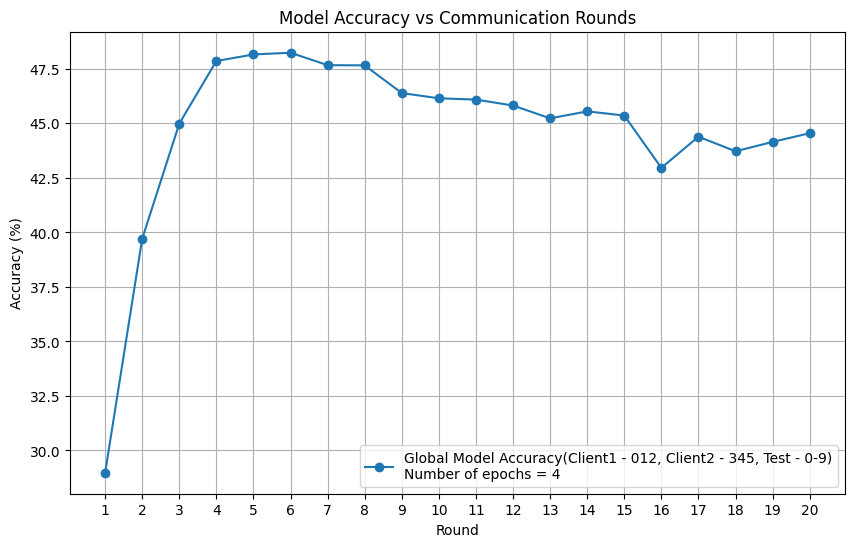

In [1]:
import matplotlib.pyplot as plt
import re

# Read accuracy values from the file
accuracies = []
with open('textfiles/accuracy_non_iid_4epochs.txt', 'r') as file:
    for line in file:
        # Use regex to find the numeric accuracy value (e.g., 17.83 from 'Round 1: 17.83%')
        match = re.search(r'(\d+\.\d+)%', line)
        if match:
            accuracies.append(float(match.group(1)))

# Generate x-axis (rounds)
rounds = range(1, len(accuracies) + 1)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(rounds, accuracies, marker='o', label='Global Model Accuracy(Client1 - 012, Client2 - 345, Test - 0-9)\nNumber of epochs = 4')
plt.title('Model Accuracy vs Communication Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.xticks(rounds)  # Show each round on the x-axis
plt.grid(True)
plt.legend()
plt.show()
